In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt
import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.special as sf
import matplotlib as mpl
from astropy.io import ascii
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
plt.rcParams['font.size'] = 13
plt.rcParams['figure.figsize'] = [7,5]
import datetime as dt

In [2]:
def aper_init(amp, pixsize_x, pixsize_y, pixn_x, pixn_y, shape=0, r=2, a=.5, b=8, d=2, sigma=2):
    """
    pixsize: physical size of each pixel
    pixn: number of pixels in each dimension
    shape: shape of the E field
    amp = amplitude
    r = radius
    a = width of a slit
    b = height of a slit
    d = separation between two slits
    sigma = width of a gaussian
    """
    aper_plane = np.ones(shape=(pixn_x,pixn_y))*0
    #form physical dimension of x and y
    x = np.linspace(0,pixsize_x*(pixn_x-1), pixn_x)
    y = np.linspace(0,pixsize_y*(pixn_y-1), pixn_y)
    x,y = x-x.max()/2, y-y.max()/2 #place the origin at the center of the aperture plane
    
    if shape==0: #circle
        E_idx = (x[np.newaxis,:])**2 + (y[:,np.newaxis])**2 < r**2
        aper_plane[E_idx] = amp
    if shape==1: #single slit
        E_idx = ((x[np.newaxis,:]>0)&(x[np.newaxis,:]<a)) & ((y[:,np.newaxis]>(-b/2))&(y[:,np.newaxis]<(b/2)))
        aper_plane[E_idx] = amp
    if shape==2: #double slit
        E_idx1 = ((x[np.newaxis,:]>(-d/2-a/2))&(x[np.newaxis,:]<(-d/2+a/2))) & ((y[:,np.newaxis]>(-b/2))&(y[:,np.newaxis]<(b/2)))
        E_idx2 = ((x[np.newaxis,:]>(d/2-a/2))&(x[np.newaxis,:]<(d/2+a/2))) & ((y[:,np.newaxis]>(-b/2))&(y[:,np.newaxis]<(b/2)))
        aper_plane[E_idx1|E_idx2] = amp
    if shape==3: # gaussian
        xx,yy = np.meshgrid(x, y)
        aper_plane = np.exp(-(xx**2+yy**2)/(2*sigma**2))
    
    fig = plt.figure(figsize=(17,8))
    ax1 = fig.add_subplot(121)
    ax1.imshow(aper_plane, extent=(x.min(),x.max(),y.min(),y.max()),cmap='plasma')
    ax2 = fig.add_subplot(122)
    #ax2.imshow(np.abs(np.fft.fftshift(np.fft.fft2(aper_plane))))
    ax2.imshow(np.abs(np.fft.fftshift(np.fft.fft2(aper_plane))),cmap='plasma')
    return x,y,aper_plane



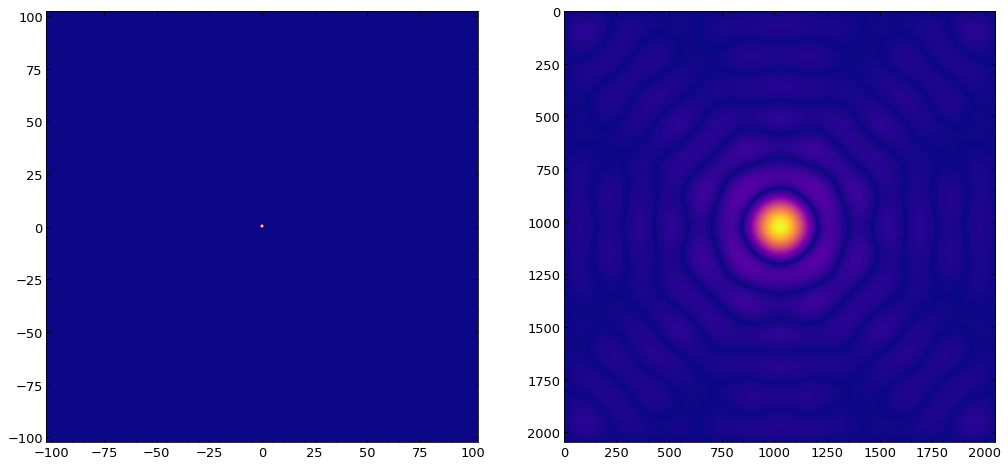

In [33]:
amp = aper_init(100., 0.1,0.1,2048,2048,shape=0,r=0.7)

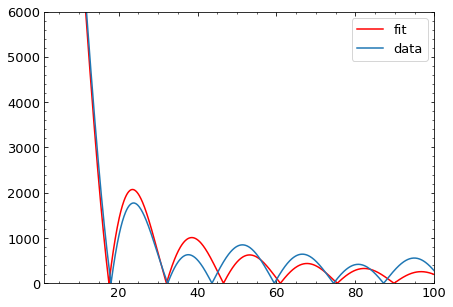

In [34]:
def airy(x,A,k):
    jinc = sf.jn(1,k*x) / (k*x)
    airy = np.abs(A * jinc)
    return(airy)
fft = np.abs(np.fft.fftshift(np.fft.fft2(amp[2])))
(fit,err) = opt.curve_fit(airy, amp[0], fft[int(len(amp[1])/2)],absolute_sigma=True)
plt.plot(amp[0], airy(amp[0],fit[0],fit[1]),color='red',label='fit')
plt.plot(amp[0], fft[int(len(amp[1])/2)],label='data')
plt.xlim(1,100)
plt.ylim(0,6e3)
plt.legend()

In [126]:
# given K_X, K_Y of the fourier plane (output K vector), want to find the angle theta_x and theta_y 
def position(K_X, K_Y, lam):
    k = 2*np.pi/lam #wave vector
    theta_x = np.arcsin(K_X/k)
    theta_y = np.arcsin(K_Y/k)
    return(theta_x, theta_y)
position(5, 3, 0.001)

(0.0007957747994478717, 0.00047746484741717607)

In [136]:
1/(np.pi*5.86e-26*65624**2)/3.086e25

4.087249905628265e-11

In [139]:
1/8

0.125

In [1]:
%run Fraunhofer.py

20


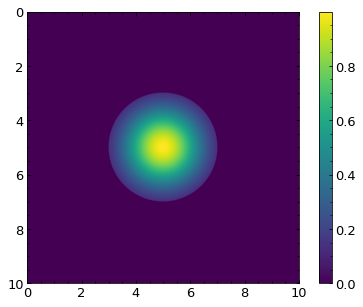

In [5]:
starttime = dt.datetime.now()
screen = {}
screen['N'] = 4096
screen['D'] = 10
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, 1.0)
InCircle(screen, center, 2.0)
# c2 = (center[0]-0.2, center[1]-0.1)
# CircleAtten(screen,c2,0.1,1.3)
# c2 = (center[0]+0.1, center[1]+0.3)
# CircleAtten(screen,c2,0.1,1/1.3)
# c2 = (center[0]+0.3, center[1]-0.1)
# CircleAtten(screen,c2,0.1,1.3)
# c2 = (center[0]-0.3, center[1]+0.2)
# CircleAtten(screen,c2,0.1,1/1.3)
ScreenFFT(screen)

lam = 0.002 #m wavelength
kphot = 2*np.pi/lam
thetamaxdeg = 4.0
thetamax = 2*np.pi/180. # 2 degrees in radians
theta_vec = np.linspace(-thetamax,thetamax,1024) 
II0 = Project_I_on_thetagrid(theta_vec,screen,lam) 
endtime = dt.datetime.now()
t = (endtime-starttime).seconds
print(t)

plt.imshow(screen['E'],extent=(0,screen['D'],screen['D'],0))
plt.colorbar()

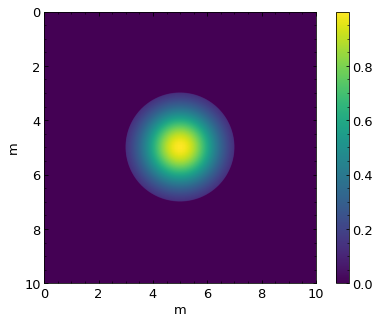

In [4]:

plt.imshow(screen['E'],extent=(0,screen['D'],screen['D'],0))
plt.xlabel('m')
plt.ylabel('m')
plt.colorbar()

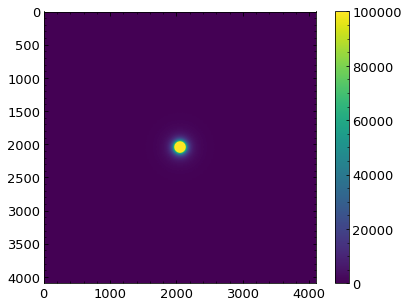

In [7]:
plt.imshow(screen['I'],vmax=1e5)
plt.colorbar()

Text(0, 0.5, 'degrees')

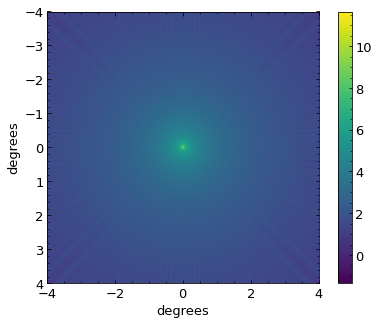

In [6]:
#plt.imshow(np.log10(screen['I']/np.max(screen['I'])), vmin=-5,interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg]) 
plt.imshow(np.log10(II0), interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg]) 
plt.colorbar()
plt.xlabel('degrees')
plt.ylabel('degrees')

In [95]:
def Project_I_on_thetagrid(theta_vec,screen,lam):
    # Run after you've calculated the intensity as a function of kx, ky.
    # thetavec = 1D array of positions to be used for thetax, and for thetay
    #
    # Make 2D arrays of thetax, thetay coordinate for our map
    # We use the "_grid" suffix to indicate things that are 2D arrays associated
    # with the (new) thetax_grid, thetay_grid created next.
    N_thetagrid = len(theta_vec)
    thetax_grid, thetay_grid = np.meshgrid(theta_vec,theta_vec)
    thetay_grid = np.flipud(thetay_grid)
    #
    kphot = 2*np.pi/lam    # photon k vector.
    #
    # Find kx and ky at each (thetax,thetay) grid spot
    #
    #kx_grid = kphot*thetax_grid/(np.pi/2) # fix this
    #ky_grid = kphot*thetay_grid/(np.pi/2)
    kx_grid = kphot*np.sin(thetax_grid) 
    ky_grid = kphot*np.sin(thetay_grid)
    #
    # Now look at the original kx,ky map of our FT screen.
    #
    I_grid = np.zeros((N_thetagrid, N_thetagrid))
    
    dk = screen['kx'][0,1]-screen['kx'][0,0]
    for xx in range(N_thetagrid):
        for yy in range(N_thetagrid):
            kx = kx_grid[yy,xx]
            ky = ky_grid[yy,xx]
            #
            nx = kx/dk + screen['N']/2  # what element is this in the screen's kx,ky
            ny = ky/dk + screen['N']/2
            #
            # find the four values of kx,ky that surround
            nx1 = int(np.floor(nx))
            nx2 = int(np.ceil(nx))
            ny1 = int(np.floor(ny))
            ny2 = int(np.ceil(ny))
            # Go through four points surrounding our grid point's position and take weighted average.
            numsum = 0
            denomsum = 0
            for pt in [(nx1,ny1), (nx1,ny2), (nx2,ny1), (nx2,ny2)]:
                rr2 = (kx - screen['kx'][pt[0],pt[1]])**2 + (ky - screen['ky'][pt[0],pt[1]])**2
                w = 1/rr2
                numsum += w*screen['I'][pt[0],pt[1]]
                denomsum += w
                #numsum += screen['I'][pt[0],pt[1]]
                #denomsum += 1
            I_grid[xx,yy] = numsum/denomsum
            #I_grid[xx,yy] = screen['I'][nx2,ny1]
        
    return I_grid

In [21]:
starttime = dt.datetime.now()
screen = {}
screen['N'] = 4096
screen['D'] = 10
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, 1.0)
InCircle(screen, center, 1.0)
#c2 = (center[0]-0.2, center[1]-0.1)
c2 = (center[0], center[1])
CircleAtten(screen,c2,0.1,1.3)
# c2 = (center[0]+0.1, center[1]+0.3)
# CircleAtten(screen,c2,0.1,1/1.3)
# c2 = (center[0]+0.3, center[1]-0.1)
# CircleAtten(screen,c2,0.1,1.3)
# c2 = (center[0]-0.3, center[1]+0.2)
# CircleAtten(screen,c2,0.1,1/1.3)
ScreenFFT(screen)

lam = 0.002 #m wavelength
kphot = 2*np.pi/lam
thetamaxdeg = 2.0
thetamax = thetamaxdeg*np.pi/180. # 2 degrees in radians
theta_vec = np.linspace(-thetamax,thetamax,1024) 
II1 = Project_I_on_thetagrid(theta_vec,screen,lam) 
# endtime = dt.datetime.now()
# t = (endtime-starttime).seconds
# print(t)

# plt.imshow(screen['E'],extent=(0,screen['D'],screen['D'],0))
# plt.colorbar()

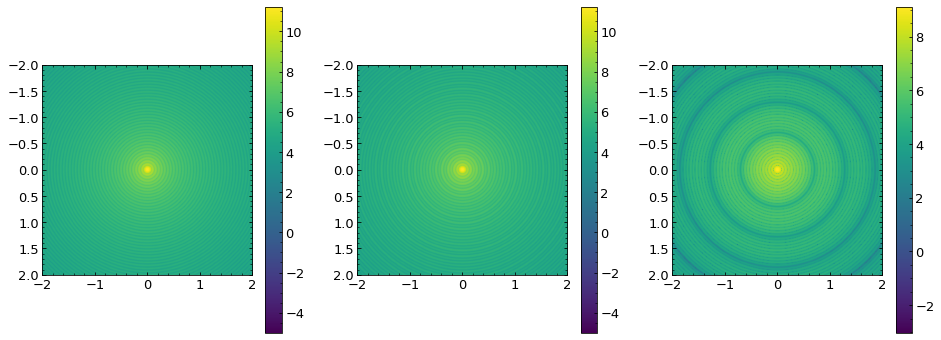

In [23]:
Idiff = II1-II0
plt.rcParams['figure.figsize'] = [16, 6]
plt.subplot(1,3,1)
plt.imshow(np.log10(np.abs(II0)),vmin=-5,interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg])
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(np.log10(np.abs(II1)),vmin=-5,interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg])
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(np.log10(np.abs(Idiff)),interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg])
plt.colorbar()



In [102]:
1.22*lam/0.5*180/np.pi

0.2796034040238417

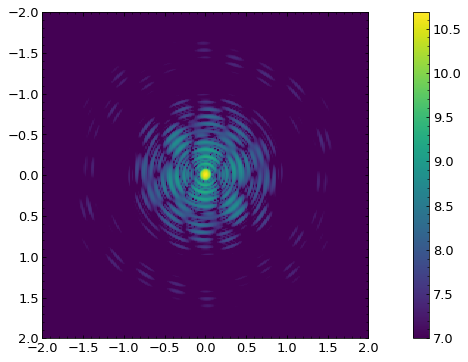

In [53]:
plt.imshow(np.log10(np.abs(Idiff)),vmin=7,interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg])
plt.colorbar()

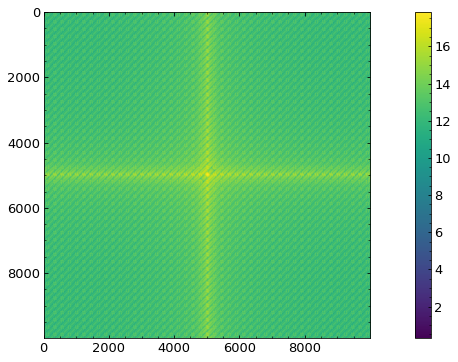

In [54]:
psd0 = np.fft.fftshift(np.abs(np.fft.fft2(II0))) # exactly the same thing as ifft2. does iFFT to transfer back to the aperture coordinates?
psd1 = np.fft.fftshift(np.abs(np.fft.fft2(II1)))
plt.imshow(np.log10(np.abs(psd0)))
plt.colorbar()


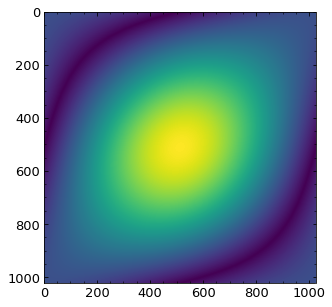

In [10]:
test = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(II0)))
plt.imshow(np.abs(test))